In [20]:
import os
import json
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score, KFold
import seaborn as sns
from datetime import date
import matplotlib.pyplot as plt
import plotly.express as px
import pickle
import joblib 
import json

In [2]:
os.chdir('..')

# Define Functions

In [3]:
def preparePredictiveData(df):
    df.sort_values(by = 'sale_date', inplace=True)
    train = df.query('sale_date <= @date1').copy()
    test = df.query('sale_date > @date1').copy()
    train.drop('sale_date', axis=1, inplace=True)
    test.drop('sale_date', axis=1, inplace=True)
    return train.drop(columns = ['sale_price']), test.drop(columns = ['sale_price']), train["sale_price"], test["sale_price"]

def prepareCrossData(df, train_index, test_index):
    train = df.iloc[train_index].copy()
    test = df.iloc[test_index].copy()
    train.drop('sale_date', axis=1, inplace=True)
    test.drop('sale_date', axis=1, inplace=True)
    return train.drop(columns = ['sale_price']), test.drop(columns = ['sale_price']), train["sale_price"], test["sale_price"]

In [18]:
def predict(model, df): 
    X_train, X_test, y_train, y_test = preparePredictiveData(df)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('R2 Score' % r2_score(y_test, y_pred))
    y_test = y_test.to_frame()
    y_test["pred"] = y_pred
    if (type(model).__name__ == 'LinearRegression'):  
        return y_test, get_coef(model, X_train.columns)
    else: 
        return y_test, get_feature_importance(model, X_train.columns)

def predictCross(model, df, train_index, test_index):
    X_train, X_test, y_train, y_test = prepareCrossData(df, train_index, test_index)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(r2_score(y_test, y_pred))
    y_test = y_test.to_frame()
    y_test["pred"] = y_pred
    if (type(model).__name__ == 'LinearRegression'):  
        return y_test, get_coef(model, X_train.columns)
    else: 
        return y_test, get_feature_importance(model, X_train.columns)

In [5]:
def get_score(model, df):
    X_train, X_test, y_train, y_test = preparePredictiveData(df, date1)
    print("{}: {}".format(type(model).__name__, model.score(X_test, y_test)))
    
def get_score2(model, x, y):
    # Split dataset into train and validation subsets:
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
    model.fit(X_train, y_train)
    print("{}: {}".format(type(model).__name__, model.score(X_test, y_test)))

def get_cvs(model, x, y, cv): 
    scores = cross_val_score(model, x, y, scoring='r2', cv=cv)
    print("R2: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))
    
def get_feature_importance(model, x_cols): 
    return pd.DataFrame(model.feature_importances_, index = x_cols, columns=['importance']).sort_values('importance',ascending=False)

def get_coef(model, x_cols): 
    return pd.DataFrame(model.coef_, index = x_cols, columns=['coef']).sort_values('coef',ascending=False)

In [6]:
# Add functions to test
lr = LinearRegression(normalize=True, n_jobs=-1)
rf = RandomForestRegressor(n_estimators = 50, max_depth = 16, n_jobs = -1, random_state=0)
kf = KFold(n_splits=5, shuffle=True, random_state=None)
kf_noshuf = KFold(n_splits=5, shuffle=False, random_state=None)

# Import Data

In [7]:
df_lr = pd.read_csv('ENG_DATA/SELECTED/05-14_lr_log.csv', index_col = [0])
df_rf = pd.read_csv('ENG_DATA/SELECTED/05-14_rfe_all.csv', index_col = [0])
df_rf = df_rf.select_dtypes(exclude = 'object')
dates_neighborhoods = pd.read_csv('ENG_DATA/SELECTED/05-13_sale_neighborhood_train.csv', index_col = [0], parse_dates = ["sale_date"])

In [9]:
date1 = date(2016, 12, 31)
df_lr = df_lr.merge(dates_neighborhoods, left_index = True, right_index = True).drop("neighborhood", axis=1)
df_rf = df_rf.merge(dates_neighborhoods, left_index = True, right_index = True).drop("neighborhood", axis=1)

In [10]:
df_out = df_rf[["sale_date", "sale_price"]].copy()

In [11]:
lr_cols = df_lr.drop(["sale_price", "sale_date"], axis=1).columns
rf_cols = df_rf.drop(["sale_price", "sale_date"], axis=1).columns

# Predictive Models

In [12]:
df_out_pred = df_out.query("sale_date > @date1").copy()

In [19]:
y_test_lr, df_coef = predict(lr, df_lr)
y_test_rf, df_features = predict(rf, df_rf)
df_out_pred = pd.merge(df_out_pred, y_test_lr[['pred']],how = 'left',left_index = True, right_index = True)
df_out_pred = pd.merge(df_out_pred, y_test_rf[['pred']],how = 'left',left_index = True, right_index = True, suffixes = ("_lr", "_rf"))

0.6388906495845863
Average expected loss: 0.221
Average bias: 0.208
Average variance: 0.013
0.7831109286921819
Average expected loss: 0.552
Average bias: 0.514
Average variance: 0.038


# Cross-Sectional Models

In [29]:
train, test = train_test_split(df_rf.drop(["sale_date"], axis=1), test_size=0.2)

In [68]:
get_score2(lr, df_lr.drop(["sale_date", "sale_price"], axis=1), df_lr.sale_price)
get_score2(rf, df_rf.drop(["sale_date", "sale_price"], axis=1), df_rf.sale_price)

LinearRegression: 0.8675610193492311
RandomForestRegressor: 0.9024586612625093


In [67]:
get_cvs(lr, df_lr.drop(["sale_date", "sale_price"], axis=1), df_lr.sale_price, kf)
get_cvs(rf, df_rf.drop(["sale_date", "sale_price"], axis=1), df_rf.sale_price, kf)

R2: 0.847 (+/- 0.075)
R2: 0.905 (+/- 0.007)


# Feature and Coefficient Frames

In [69]:
features_cs = get_feature_importance(rf, rf_cols)

In [70]:
coef_cs = get_coef(lr, lr_cols)

In [71]:
df_features = pd.merge(df_features, features_cs,how = 'left',left_index = True, right_index = True, suffixes = ("_p", "_cs"))

In [72]:
df_coef = pd.merge(df_coef, coef_cs,how = 'left',left_index = True, right_index = True, suffixes = ("_p", "_cs"))

# Visualizations

In [ ]:
import plotly.express as px

In [ ]:
fig = px.scatter(df_output, x="sale_date", y="pred_diff", trendline = "ols", title= "Difference in Prediction Over 2-Year Test Data")
fig.show()

In [ ]:
df_melted = df_output[["sale_date", "sale_price", "predlr", "predrf"]].melt(id_vars = "sale_date")

In [ ]:
fig = px.scatter(df_melted, x="sale_date", y="value", color = "variable", title= "Predictions Over 2-Year Test Data")
fig.show()

In [ ]:
fig = px.scatter(df_melted.query("value < 15e6"), x="sale_date", y="value", color = "variable", title= "Predictions Over 2-Year Test Data")
fig.show()

In [ ]:
df_output['sale_price_bins'] = pd.qcut(df_output['sale_price'], 10, False)

In [ ]:
df_binned = df_output.groupby('sale_price_bins').mean()
df_binned.reset_index(inplace=True)
df_melted_bins = df_binned[["sale_price_bins", "sale_price", "predlr", "predrf"]].melt(id_vars = "sale_price_bins")

In [ ]:
fig = px.bar(df_melted_bins, x="sale_price_bins", y="value", color = "variable", barmode='group', title= "Sale-Price Quintile Binned Bar Chart of Prediction ")
fig.show()

In [ ]:
df_output['sale_date_bins'] = pd.qcut(df_output['sale_date'], 10, False)

In [ ]:
df_binned_2 = df_output.groupby('sale_date_bins').mean()
df_binned_2.reset_index(inplace=True)
df_melted_bins_2 = df_binned_2[["sale_date_bins", "sale_price", "predlr", "predrf"]].melt(id_vars = "sale_date_bins")

In [ ]:
fig = px.bar(df_melted_bins_2, x="sale_date_bins", y="value", color = "variable", barmode='group', title= "Time-Based Quintile Binned Bar Chart of Prediction ")
fig.show()

In [ ]:
def r_squared(data):
    d = {}
    d['r2-lr'] = r2_score(data['sale_price'], data['predlr'])
    d['r2-rf'] = r2_score(data['sale_price'], data['predrf'])
    return pd.Series(d)

In [ ]:
df_r2_binned = df_output.groupby('sale_date_bins').apply(r_squared)

In [ ]:
df_r2_binned.reset_index(inplace=True)

In [ ]:
fig = px.line(df_r2_binned.melt(id_vars = 'sale_date_bins'), x="sale_date_bins", y="value", color = "variable", title= "Time-Based Quintile Binned R-Squared Comparison")
fig.show()

# Log Transformation
## plot sale price before and after
heredoskadacitiy 

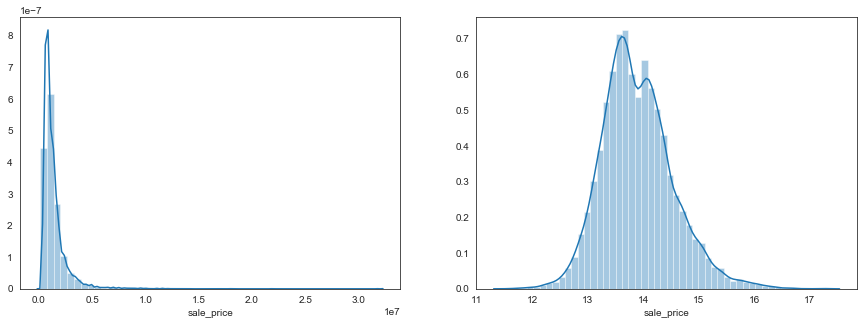

In [56]:
sns.set_style("white")
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.distplot(np.exp(df_lr['sale_price']), ax=ax[0])
sns.distplot(df_lr['sale_price'], ax=ax[1])
plt.show()

In [62]:
fig = px.scatter(df_rf, x="sale_date", y="sale_price", trendline = "ols", title= "Sales Price over Time")
fig.show()

# Feature Importance

In [77]:
df_features.reset_index(inplace=True)

Index(['level_0', 'index', 'importance_p', 'importance_cs'], dtype='object')

In [96]:
df_coef.reset_index(inplace=True)

In [102]:
df_coef["coef_p"] = np.abs(df_coef["coef_p"])
df_coef["coef_cs"] = np.abs(df_coef["coef_cs"])

In [104]:
df_coef

index        coef_p       coef_cs
0        longitude  2.105926e+07  2.002491e+07
1         latitude  5.263319e+05  5.427261e+05
2        elevation  5.355993e-01  5.033592e-01
3          baths_2  2.476132e-01  2.449483e-01
4        type_4STR  1.858184e-01  1.792088e-01
..             ...           ...           ...
80        burglary  2.424403e-01  2.596472e-01
81      enrollment  3.015592e-01  3.254509e-01
82  on_market_year  4.160738e+01  1.486135e+01
83      latitude_2  7.243655e+04  7.469486e+04
84     longitude_2  2.190179e+06  2.082607e+06

[85 rows x 3 columns]

In [106]:
df_coef.sort_values(by='coef_p', ascending=False, inplace=True)

In [85]:
tidy = df_features.drop('level_0', axis=1).melt(id_vars='index').rename(columns=str.title)

In [107]:
tidy2 = df_coef.head(15).melt(id_vars='index').rename(columns=str.title)

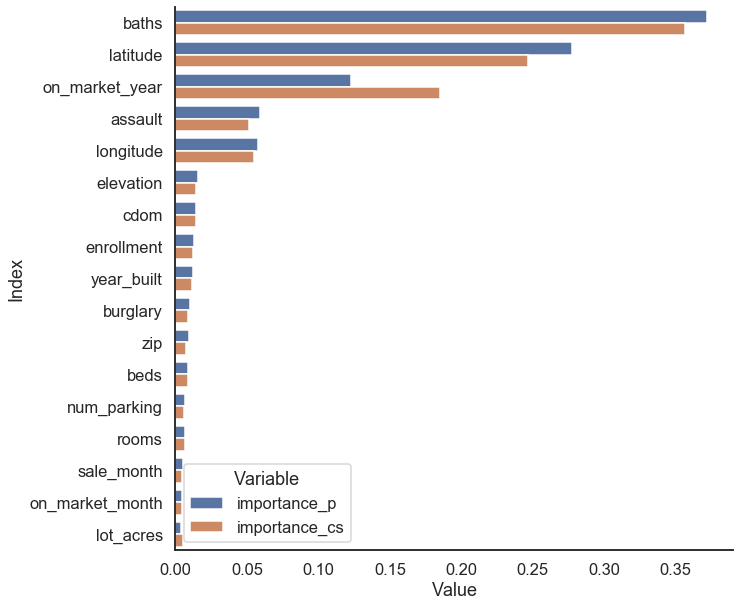

In [95]:
# Initialize the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 10))
sns.set(style="white", context="talk", color_codes=True)
sns.barplot(x='Value', y='Index', hue='Variable', palette="deep", data=tidy, ax=ax)
sns.despine(fig)

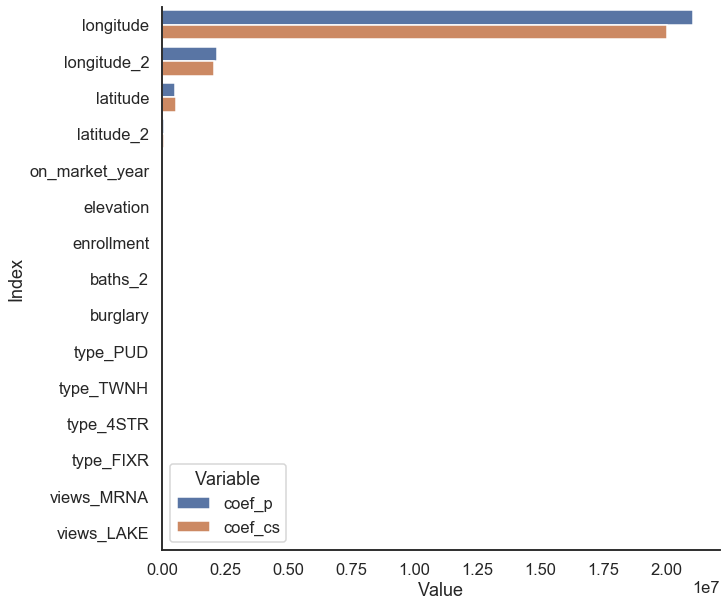

In [108]:
# Initialize the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(x='Value', y='Index', hue='Variable', palette="deep", data=tidy2, ax=ax)
sns.despine(fig)